## Imports

In [2]:
! pip install matplotlib

  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (306 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [3]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import os
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize, transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

In [4]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DataLoaders and datasets + Preprocessing to standardize image size

In [5]:
# Resize the image and do a center crop, and store them on a tensor
img_size = (224, 224)
batch_size=32
train_data_dir = '/home/jovyan/BrainTumour/Training'
test_data_dir = '/home/jovyan/BrainTumour/Testing'

#preprocessing : standardizing the sizes 
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

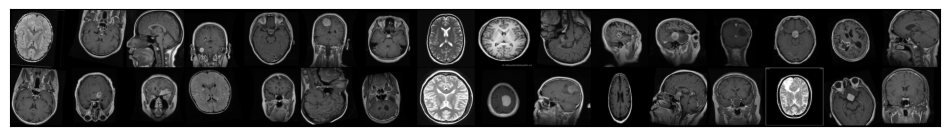

In [7]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

# ResNet

## Model Definition

In [8]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1  # Set expansion to 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [22]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        #self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [23]:
def train(model, train_loader, test_loader, training_name,saved_weights_dir, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_number, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        
        epoch_loss /= len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        model.eval()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss /= len(test_loader)
        epoch_acc = correct / total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'saved weights to {savedDir}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies


In [24]:
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()



In [25]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Tester code

In [15]:
#loads weights, run against all test and train for all epochs to recreate loss and accuracy graph
def load_weights_and_test(model,test_loader,epochs,training_name,saved_weights_dir):
    criterion = nn.CrossEntropyLoss()    
    # recreate test
    test_losses = []
    test_accuracies = []
    
    
    for epoch in range(epochs):
        print(epoch)
        path_model_params=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth' #edit this accordingly to folder
        model.load_state_dict(torch.load(path_model_params))
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')    
    return test_losses, test_accuracies

In [26]:
#loads weights, run against all test and train for all epochs to recreate loss and accuracy graph
def load_weights_and_test(model,train_loader,test_loader,epochs,training_name,saved_weights_dir):
    criterion = nn.CrossEntropyLoss()

    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        path_model_params=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth' #edit this accordingly to folder
        model.load_state_dict(torch.load(path_model_params))
        model.eval()

        #recreate train
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
    
    
    # recreate test
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
      
    return train_losses,train_accuracies,test_losses, test_accuracies

In [27]:
def plot_test_graph( test_acc):

    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [28]:
def plot_test_loss_graph(test_loss):
    
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' Test Loss vs. Epochs')
    plt.legend()
    plt.show()

# Running Models

## Model 1

In [15]:
# Instantiate ResNet model
model = ResNet(block=BasicBlock, layers=[2, 2, 2]).to(device)
print(model)
training_name="ResNet1"
saved_weights_dir="/home/jovyan/ResNet_weights"
max_epochs=15


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.4375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.4895833333333333
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.5546875
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.55
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.5625
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.6026785714285714
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.59765625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.6145833333333334
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.625
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.625
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.6201923076923077
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.6205357142857143
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.61875
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.630859375
Epoch 1/15, Batch number: 16,

--- Epoch 1/15: Test loss: 1.1636, Test accuracy: 0.6674
--- Epoch 2/15: Test loss: 1.1171, Test accuracy: 0.6529
--- Epoch 3/15: Test loss: 2.6188, Test accuracy: 0.5683
--- Epoch 4/15: Test loss: 0.7375, Test accuracy: 0.7414
--- Epoch 5/15: Test loss: 0.5296, Test accuracy: 0.8360
--- Epoch 6/15: Test loss: 0.3269, Test accuracy: 0.8924
--- Epoch 7/15: Test loss: 0.3573, Test accuracy: 0.8749
--- Epoch 8/15: Test loss: 0.2819, Test accuracy: 0.8955
--- Epoch 9/15: Test loss: 0.2672, Test accuracy: 0.8902
--- Epoch 10/15: Test loss: 0.1735, Test accuracy: 0.9321
--- Epoch 11/15: Test loss: 0.1878, Test accuracy: 0.9329
--- Epoch 12/15: Test loss: 0.3374, Test accuracy: 0.8970
--- Epoch 13/15: Test loss: 0.3177, Test accuracy: 0.9039
--- Epoch 14/15: Test loss: 0.1648, Test accuracy: 0.9481
--- Epoch 15/15: Test loss: 0.1461, Test accuracy: 0.9458


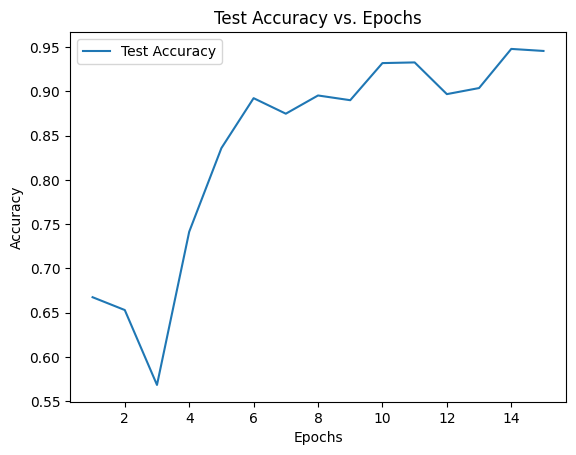

In [56]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [59]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


max accuracy:  0.9481311975591151
epoch:  14


## Model 2

In [29]:
# Instantiate ResNet model
model = ResNet(block=BasicBlock, layers=[2, 2, 2]).to(device)
print(model)
training_name="ResNet2"
saved_weights_dir="/home/jovyan/ResNet_weights"
max_epochs=15

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
# do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-4)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.328125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3645833333333333
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3515625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.4125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4739583333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.48214285714285715
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.515625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.5173611111111112
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.55
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5710227272727273
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5729166666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5817307692307693
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5915178571428571
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5895833333333333
Epoch 1/15, Batch number: 15, Cumulated a

KeyboardInterrupt: 

In [ ]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [ ]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


## Model 3

In [31]:
# Instantiate ResNet model
model = ResNet(block=BasicBlock, layers=[3, 4, 6]).to(device)
print(model)
training_name="ResNet3"
saved_weights_dir="/home/jovyan/ResNet_weights"
max_epochs=15

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.59375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.578125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.6041666666666666
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.59375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.55
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.5572916666666666
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.5446428571428571
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.52734375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.5208333333333334
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.525
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5170454545454546
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5286458333333334
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5288461538461539
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5245535714285714
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5166666666666667
Epoch 1/15, Batch number: 15, Cumulated ac

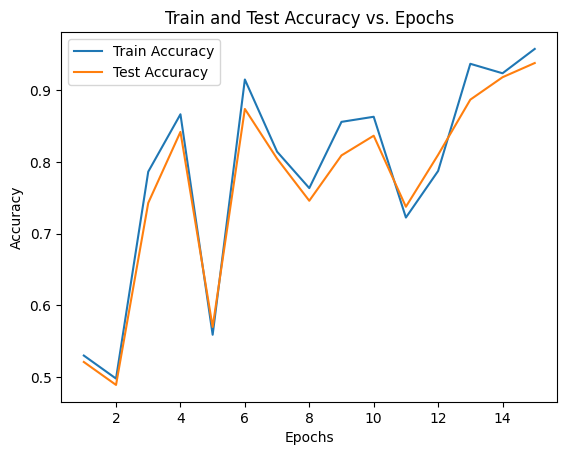

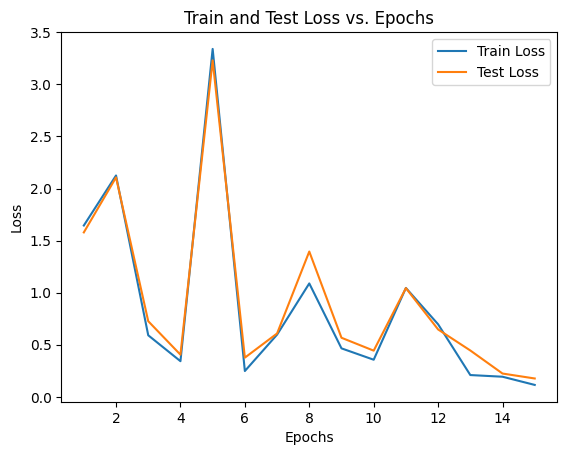

In [32]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
train_losses,train_accuracies,test_losses, test_accuracies = load_weights_and_test(model,\
                                                    train_loader, \
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

In [ ]:
# do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

In [ ]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [ ]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


## Model 4

In [16]:
# Instantiate ResNet model
model = ResNet(block=BasicBlock, layers=[3, 4, 6]).to(device)
print(model)
training_name="ResNet4"
saved_weights_dir="/home/jovyan/ResNet_weights"
max_epochs=15

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.296875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3541666666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.390625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.3875
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.421875
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.4642857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.4765625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4826388888888889
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.490625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5085227272727273
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5104166666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5264423076923077
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5357142857142857
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.55
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.560546875


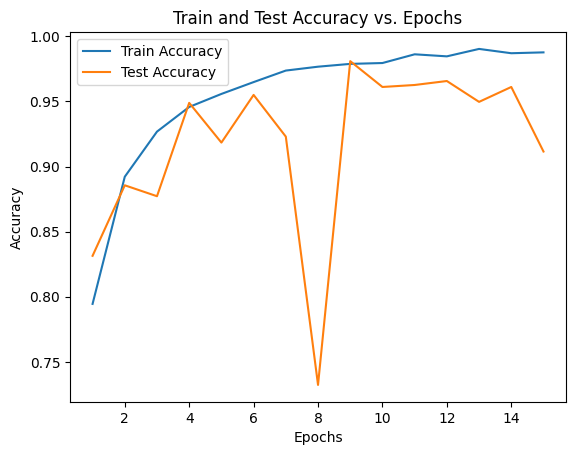

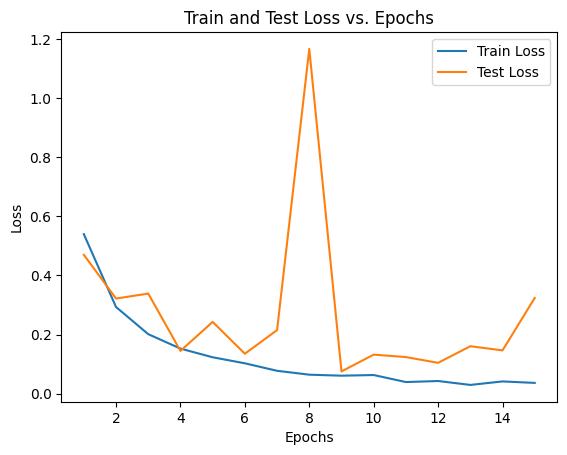

In [17]:
# do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-4)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.4701, Test accuracy: 0.8314
1
--- Epoch 2/15: Test loss: 0.3219, Test accuracy: 0.8856
2
--- Epoch 3/15: Test loss: 0.3388, Test accuracy: 0.8772
3
--- Epoch 4/15: Test loss: 0.1447, Test accuracy: 0.9489
4
--- Epoch 5/15: Test loss: 0.2429, Test accuracy: 0.9184
5
--- Epoch 6/15: Test loss: 0.1351, Test accuracy: 0.9550
6
--- Epoch 7/15: Test loss: 0.2151, Test accuracy: 0.9230
7
--- Epoch 8/15: Test loss: 1.1671, Test accuracy: 0.7323
8
--- Epoch 9/15: Test loss: 0.0752, Test accuracy: 0.9809
9
--- Epoch 10/15: Test loss: 0.1320, Test accuracy: 0.9611
10
--- Epoch 11/15: Test loss: 0.1238, Test accuracy: 0.9626
11
--- Epoch 12/15: Test loss: 0.1043, Test accuracy: 0.9657
12
--- Epoch 13/15: Test loss: 0.1605, Test accuracy: 0.9497
13
--- Epoch 14/15: Test loss: 0.1465, Test accuracy: 0.9611
14
--- Epoch 15/15: Test loss: 0.3240, Test accuracy: 0.9115


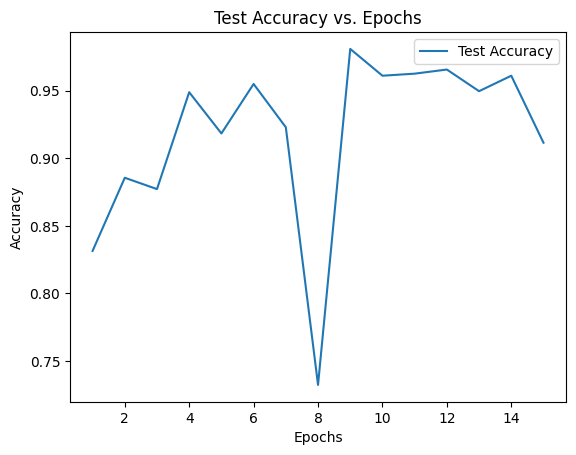

In [18]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [19]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


max accuracy:  0.9809305873379099
epoch:  9


## Model 5

In [20]:
# Instantiate ResNet model
model = ResNet(block=BasicBlock, layers=[3, 4, 23]).to(device)
print(model)
training_name="ResNet5"
saved_weights_dir="/home/jovyan/ResNet_weights"
max_epochs=15

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.21875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.296875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.31875
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.32142857142857145
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.35546875
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.3680555555555556
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.3806818181818182
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.3932291666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.40625
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.4263392857142857
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.43125
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.443359375
Epoch 1/15, Batch numb

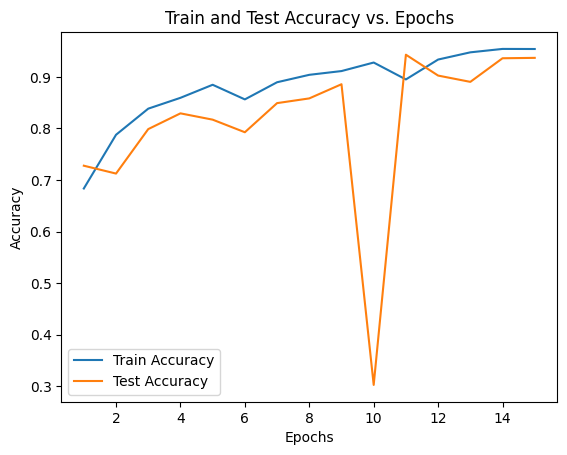

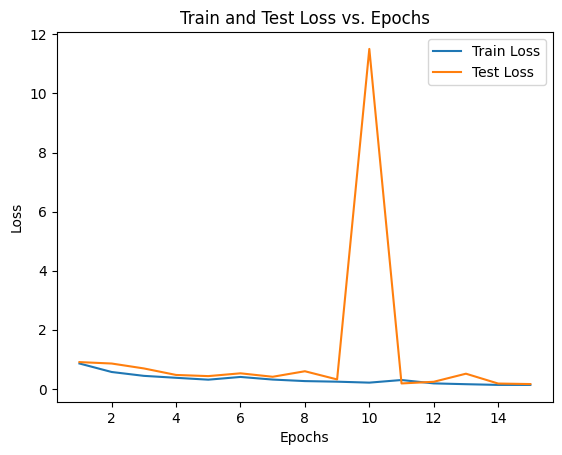

In [21]:
# do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.9049, Test accuracy: 0.7277
1
--- Epoch 2/15: Test loss: 0.8567, Test accuracy: 0.7124
2
--- Epoch 3/15: Test loss: 0.6905, Test accuracy: 0.7986
3
--- Epoch 4/15: Test loss: 0.4697, Test accuracy: 0.8291
4
--- Epoch 5/15: Test loss: 0.4305, Test accuracy: 0.8169
5
--- Epoch 6/15: Test loss: 0.5252, Test accuracy: 0.7925
6
--- Epoch 7/15: Test loss: 0.4082, Test accuracy: 0.8490
7
--- Epoch 8/15: Test loss: 0.5953, Test accuracy: 0.8581
8
--- Epoch 9/15: Test loss: 0.3183, Test accuracy: 0.8856
9
--- Epoch 10/15: Test loss: 11.5088, Test accuracy: 0.3028
10
--- Epoch 11/15: Test loss: 0.1821, Test accuracy: 0.9428
11
--- Epoch 12/15: Test loss: 0.2386, Test accuracy: 0.9024
12
--- Epoch 13/15: Test loss: 0.5122, Test accuracy: 0.8902
13
--- Epoch 14/15: Test loss: 0.1791, Test accuracy: 0.9359
14
--- Epoch 15/15: Test loss: 0.1614, Test accuracy: 0.9367


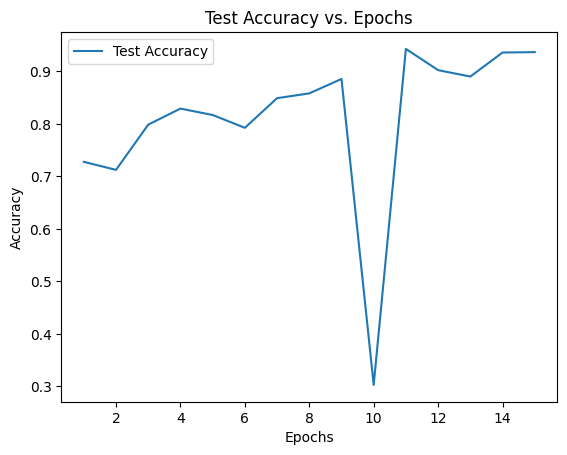

In [22]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [23]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


max accuracy:  0.9427917620137299
epoch:  11


## Model 6

In [24]:
# Instantiate ResNet model
model = ResNet(block=BasicBlock, layers=[3, 4, 23]).to(device)
print(model)
training_name="ResNet6"
saved_weights_dir="/home/jovyan/ResNet_weights"
max_epochs=15

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.359375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3645833333333333
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3671875
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.4125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4583333333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.46875
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.484375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.5034722222222222
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.496875
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5170454545454546
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5260416666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5288461538461539
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5334821428571429
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5291666666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy

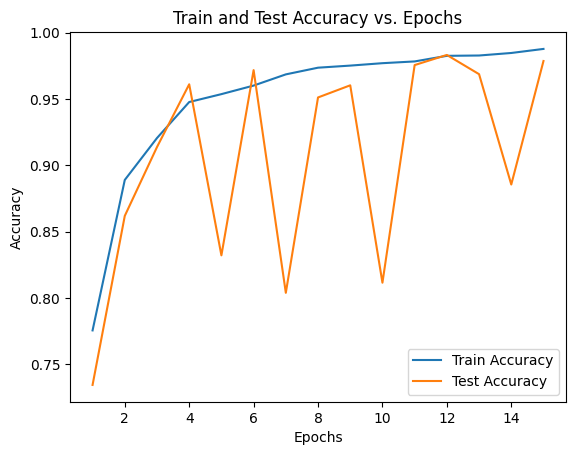

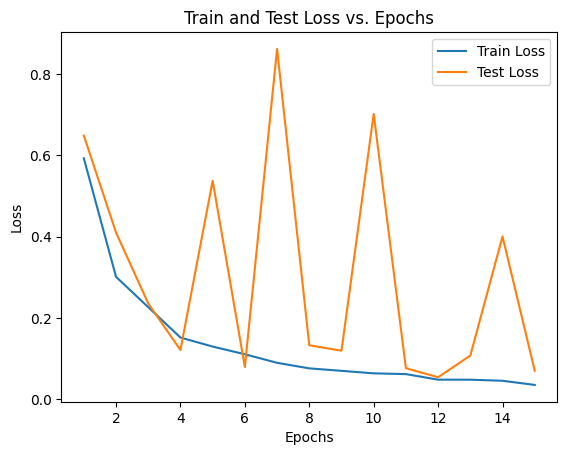

In [25]:
# do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-4)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.6482, Test accuracy: 0.7346
1
--- Epoch 2/15: Test loss: 0.4100, Test accuracy: 0.8619
2
--- Epoch 3/15: Test loss: 0.2355, Test accuracy: 0.9138
3
--- Epoch 4/15: Test loss: 0.1210, Test accuracy: 0.9611
4
--- Epoch 5/15: Test loss: 0.5373, Test accuracy: 0.8322
5
--- Epoch 6/15: Test loss: 0.0792, Test accuracy: 0.9718
6
--- Epoch 7/15: Test loss: 0.8615, Test accuracy: 0.8040
7
--- Epoch 8/15: Test loss: 0.1327, Test accuracy: 0.9512
8
--- Epoch 9/15: Test loss: 0.1194, Test accuracy: 0.9603
9
--- Epoch 10/15: Test loss: 0.7016, Test accuracy: 0.8116
10
--- Epoch 11/15: Test loss: 0.0764, Test accuracy: 0.9756
11
--- Epoch 12/15: Test loss: 0.0541, Test accuracy: 0.9832
12
--- Epoch 13/15: Test loss: 0.1073, Test accuracy: 0.9687
13
--- Epoch 14/15: Test loss: 0.4004, Test accuracy: 0.8856
14
--- Epoch 15/15: Test loss: 0.0700, Test accuracy: 0.9786


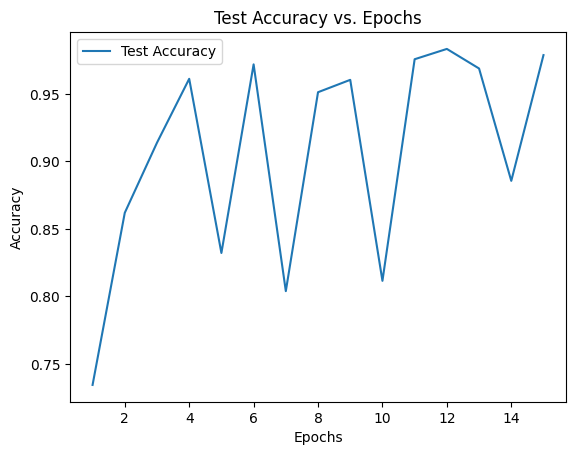

In [26]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [27]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


max accuracy:  0.9832189168573608
epoch:  12
